In [2]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, callbacks, Sequential
#import tensorflow_addons as tfa
import numpy as np
import time
from network_functions import *
from data_generation_functions import *
from tqdm import trange

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150

In [9]:
data = np.load("data/Mar14_x32_noisy.npz")
c_data = data['c_in'] 
s_data = data['s_in'] 
w0 = data['w_in']           # Omega vector for data generation
T_train = data['T_train']      # Time vector for training data (based on the experimental data)
w_train = data['w_train']      # Omega vector for training data
print('-- data loaded')

x_train, x_test, y_train, y_test = numpy_train_test_split( c_data, s_data, test_size=0.15, shuffle=True, seed=2)

print('-- data split for training:')
print("  x_train = ",np.shape(x_train))
print("  y_train = ",np.shape(y_train))
print("  x_test = ",np.shape(x_test))
print("  y_test = ",np.shape(y_test))

data_exp = np.load("experimental_data/24sept_q0q3.npz")

-- data loaded
-- data split for training:
  x_train =  (106254, 150)
  y_train =  (106254, 501)
  x_test =  (18751, 150)
  y_test =  (18751, 501)


In [11]:
paramchar = "9.93_fil=80_ker=21_dr0.05_ps=2_LRini=0.001_LRmin=1e-06_bs=64_ep=2_nt=3_Mar14_x32_noisy_20_noises"
model = models.load_model("TRAINED_NETWORKS/MODEL_" + paramchar + ".h5", compile=False)
final_accuracy = 9.93

# 1) Full architecture summary (like PyTorch print(model))
model.summary(expand_nested=True, show_trainable=True)

# 2) Input / output sizes
print("inputs:", model.inputs)
print("input_shape:", model.input_shape)     # includes batch dim as None
print("outputs:", model.outputs)
print("output_shape:", model.output_shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv1d (Conv1D)             │ (None, 150, 80)       │      1,760 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling1d               │ (None, 75, 80)        │          0 │   -   │
│ (MaxPooling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_1 (Conv1D)           │ (None, 75, 80)        │    134,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling1d_1             │ (None, 38, 80)        │          0 │   -   │
│ (MaxPooling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_2 (Conv1D)           │ (None, 38, 40)        │     67,240 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling1d_2             │ (None, 19, 40)        │          0 │   -   │
│ (MaxPooling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_3 (Conv1D)           │ (None, 19, 40)        │     33,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling1d_3             │ (None, 10, 40)        │          0 │   -   │
│ (MaxPooling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_4 (Conv1D)           │ (None, 10, 40)        │     33,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling1d               │ (None, 20, 40)        │          0 │   -   │
│ (UpSampling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_5 (Conv1D)           │ (None, 20, 40)        │     33,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling1d_1             │ (None, 40, 40)        │          0 │   -   │
│ (UpSampling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_6 (Conv1D)           │ (None, 40, 80)        │     67,280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling1d_2             │ (None, 80, 80)        │          0 │   -   │
│ (UpSampling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_7 (Conv1D)           │ (None, 80, 80)        │    134,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling1d_3             │ (None, 160, 80)       │          0 │   -   │
│ (UpSampling1D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_8 (Conv1D)           │ (None, 160, 80)       │    134,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1d_9 (Conv1D)           │ (None, 160, 1)        │      1,681 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 160)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 160)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 501)           │     80,661 │   Y 

 Total params: 722,982 (2.76 MB)

 Trainable params: 722,982 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

inputs: [<KerasTensor shape=(None, 150, 1), dtype=float32, sparse=False, ragged=False, name=input_layer>]
input_shape: (None, 150, 1)
outputs: [<KerasTensor shape=(None, 501), dtype=float32, sparse=False, ragged=False, name=keras_tensor_461>]
output_shape: (None, 501)


# Testing model on test data

In [12]:
predictions_on_test = model.predict( x_test )

586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


In [13]:
rand_set = np.random.randint( 0, 5000 ,(5,) )

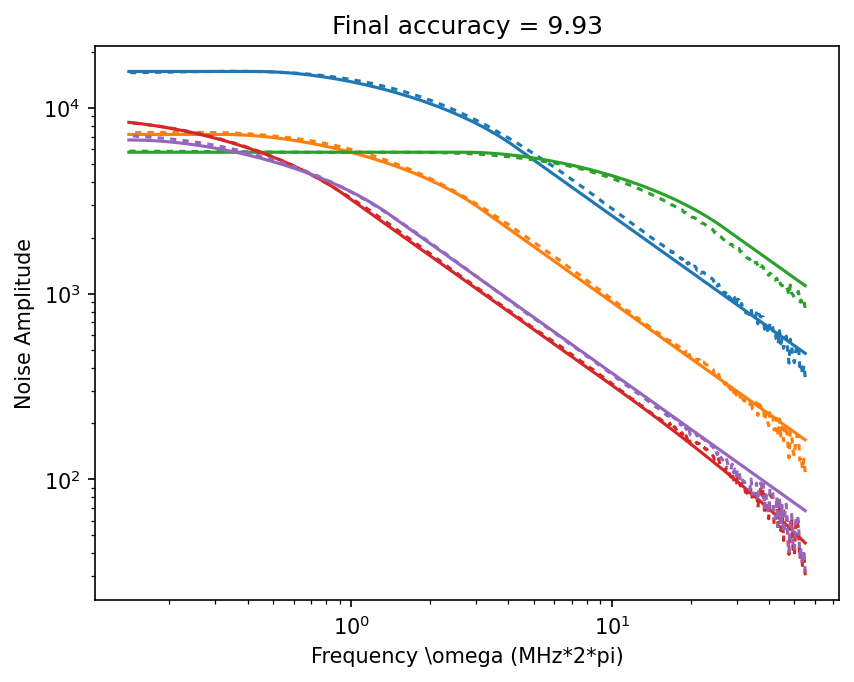

In [14]:
for i in range(len(rand_set)):
    plt.plot(w_train/1e6, y_test[ rand_set[i] ,:],color='C'+str(i))
    plt.plot(w_train/1e6, predictions_on_test[ rand_set[i] ],color='C'+str(i), dashes=[2,2,2,2])
plt.yscale('log')
plt.xscale('log')

plt.ylabel('Noise Amplitude')
plt.xlabel('Frequency \omega (MHz*2*pi)')
plt.title('Final accuracy = '+str(final_accuracy))
plt.show()

In [15]:
## To extend the noise spectrum to lower frequencies

## Calculate noise using delta-function approximation for 32-pi-pulse sequence

def delta_noise(c, t):
  w_delta = 32*np.pi/t
  s_delta = -np.pi*np.log(c)/t
  return s_delta, w_delta

In [16]:

# %%
# Create CPMG-like pulse timing array
def cpmgFilter(n, Tmax):
    tpi = np.empty([n])
    for i in range(n):
        tpi[i]= Tmax*(((i+1)-0.5)/n)
    return tpi


# %%
# Generate filter function for a given evolution time (CPMG)
def getFilter(n,w0,piLength,Tmax):

    tpi = cpmgFilter(n,Tmax)
    f = 0
    for i in range(n):
        f = ((-1)**(i+1))*(np.exp(1j*w0*tpi[i]))*np.cos((w0*piLength)/2) + f

    fFunc = (1/2)*((np.abs(1+((-1)**(n+1))*np.exp(1j*w0*Tmax)+2*f))**2)/(w0**2)
    return fFunc

In [17]:
# %%
# Generate decoherence curve corresponding to a noise spectrum (input shape = variable1.size x w.size)
def getCoherence(S,w0,T0,n,piLength):
    steps = T0.size
    C_invert = np.empty([S.shape[0],steps,])
    for i in trange(steps):
        integ = getFilter(n,np.squeeze(w0),piLength,T0[i])*S/np.pi
        integ_ans = np.trapz(y=integ,x=np.squeeze(w0))
        C_invert[:,i] = np.exp(integ_ans)
    return C_invert

In [18]:
len(w_train)

501

In [19]:
w_new = np.flipud(np.geomspace(1e3,55e6, 1001))

In [20]:
predictions_extended = spectrum_extend( predictions_on_test[:,:], w_train, w_new )

x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape: (501,)
y shape: (501,)
x shape:

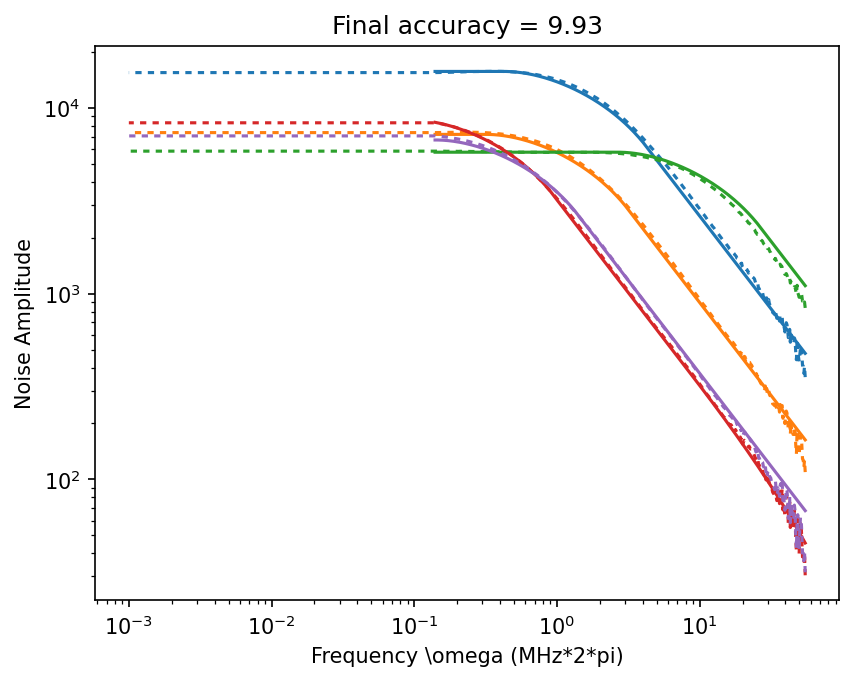

In [21]:
for i in range(len(rand_set)):
    plt.plot(w_train/1e6, y_test[ rand_set[i] ,:],color='C'+str(i))
    plt.plot(w_new/1e6, predictions_extended[ rand_set[i], : ],color='C'+str(i), dashes=[2,2,2,2])
plt.yscale('log')
plt.xscale('log')

plt.ylabel('Noise Amplitude')
plt.xlabel('Frequency \omega (MHz*2*pi)')
plt.title('Final accuracy = '+str(final_accuracy))
plt.show()

In [22]:
coh = getCoherence( predictions_extended, w_new, T_train, 32, 48e-9 )

  0%|                                                                                                        | 0/150 [00:00<?, ?it/s]/var/folders/fk/rnj11y917h749sdb9vl0w9yh0000gn/T/ipykernel_9062/705720607.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_ans = np.trapz(y=integ,x=np.squeeze(w0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.52it/s]


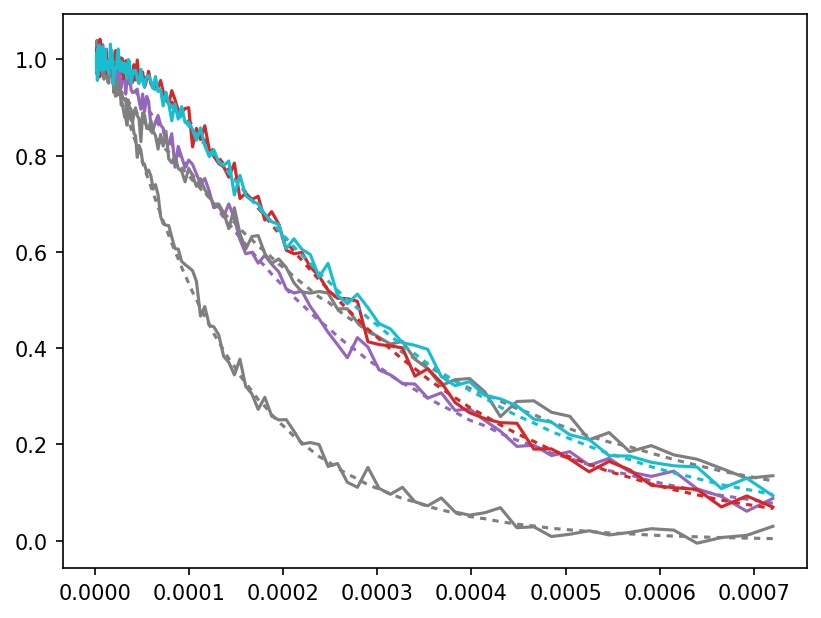

In [23]:
for i in rand_set:
    plt.plot(T_train, x_test[ i ,:],color='C'+str(i))
    plt.plot(T_train, coh[ i ,:],color='C'+str(i), dashes=[2,2,2,2])
